In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm, trange
import os
from typing import Mapping, Union, Optional, Callable, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, Subset, DataLoader, SubsetRandomSampler, TensorDataset, ConcatDataset
import warnings
warnings.filterwarnings(action='ignore')

## Dataset and data distribution

In [2]:
SAMPLING_RATE = 32000 # Hertz
INPUT_LENGTH = 5      # seconds
SPEC_SHAPE = (48,128) # spectrogram shape
FMIN=500              # Hz (~min frequency for birds)
FMAX=12500            # Hz (~max frequency for birds)

In [3]:
train_dataset_path = "./dataset"
zip_path = "../input/bird-dataset-20s/melspec_dataset_20s.zip"
DATA_MEAN = 0.3674
DATA_STD = 0.1928
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_dataset_path)

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class TimeRecombination(object):
    def __init__(self, partition):
        self.partition = partition
    
    def __call__(self, tensor):
        if tensor.shape[-1] == 256:              # 10 seconds
            if self.partition == 0:
                pieces_width = [100,50,50,56]
            if self.partition == 1:
                pieces_width = [50,40,40,30,30,30,36]
        if tensor.shape[-1] == 512:              # 20 seconds
            if self.partition == 0:
                pieces_width = [100,100,100,50,50,56,56]
            if self.partition == 1:
                pieces_width = [35,35,30,40,40,40,40,30,30,30,30,30,30,36,36]
        if tensor.shape[-1] == 768:              # 30 seconds
            if self.partition == 0:
                pieces_width = [100,100,100,50,50,50,50,50,50,56,56,56]
            if self.partition == 1:
                pieces_width = [50,50,50,40,40,40,40,40,40,30,30,30,30,30,30,30,30,30,36,36,36]
        random.shuffle(pieces_width)
        tensor = torch.split(tensor, pieces_width, dim = -1)
        return torch.cat(random.sample(tensor,len(pieces_width)), dim= -1)

In [5]:
import torchaudio.transforms as audiotransf

transform =  transforms.Compose([transforms.Grayscale(), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=DATA_MEAN, std=DATA_STD),
                                 AddGaussianNoise(0., 0.2),
                                 audiotransf.TimeMasking(time_mask_param = 150, iid_masks = True),   # MODIFY with size
                                 audiotransf.FrequencyMasking(freq_mask_param = 5, iid_masks = True),
                                 TimeRecombination(partition = 1)
                                ])
dataset = datasets.ImageFolder(root= train_dataset_path, transform=transform)
len(dataset), len(dataset.classes)

(144969, 397)

In [6]:
idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}
# dataset.class_to_idx             # lists all classes

In [7]:
# Dataset example
import plotly.express as px

training_index = random.randint(0, len(dataset))
image, label = dataset[training_index]    # image.shape = torch.Size([1, 48, 128])

example = np.array(image[0])              # 48x128

fig = px.imshow(example, 
                title=idx_to_class[int(label)],
                color_continuous_scale='gray', 
                color_continuous_midpoint=0,
                labels = dict(x = 'Time (s)',y = 'Frequency (Hz)'),
               )
fig.show()

## Metadata

In [8]:
# Load metadata file
metadata_df = pd.read_csv('../input/birdclef-2021/train_metadata.csv')
all_species = metadata_df['primary_label'].unique()
meta_df = metadata_df[["filename","primary_label","latitude","longitude","date","time","rating"]]  # retain
# TIME OF DAY NOT PRESENT ON TEST DATA: USELESS
meta_df

,filename,primary_label,latitude,longitude,date,time,rating
0,XC109605.ogg,acafly,35.3860,-84.1250,2012-08-12,09:30,2.5
1,XC11209.ogg,acafly,9.1334,-79.6501,2000-12-26,?,3.0
2,XC127032.ogg,acafly,5.7813,-75.7452,2012-01-10,15:20,3.0
3,XC129974.ogg,acafly,4.6717,-75.6283,2009-06-19,07:50,3.5
4,XC129981.ogg,acafly,4.6717,-75.6283,2009-06-19,07:50,3.5
...,...,...,...,...,...,...,...
62869,XC591680.ogg,yetvir,30.2150,-97.6505,2020-07-10,08:30,1.0
62870,XC600085.ogg,yetvir,42.3005,-72.5877,2019-05-31,09:30,5.0
62871,XC602701.ogg,yetvir,42.3005,-72.5877,2020-06-02,08:30,4.5
62872,XC614733.ogg,yetvir,32.2357,-99.8811,2019-04-27,17:30,4.0


In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

# express DATE in days (remove year)
def date_transform(date):
    return int(date.rsplit('-')[2]) + max(0, int(date.rsplit('-')[1])-1)*30
meta_df['date'] = meta_df['date'].apply(date_transform)

# express TIME in minutes
def time_transform(time):
   # exclude '?', 'xx', 'xx:xx', 'night', 'am'
    if not(any(map(str.isdigit, time))):     # if no numbers inside
        return np.random.randint(0,1440)     # method1: in this way we will not increase a specific time slot
    else:
        Q = 0
        time = time.lower()                  # AM,PM->am,pm
        if 'pm' in time:
            Q = 1
        time = time.replace('pm','')
        time = time.replace('am','')
        time = time.rsplit(':')
        minutes = 0
        if len(time)>1:
            minutes = int(time[1])
        result = (int(time[0]) + Q*12)*60 + minutes
        return( result%1440 )                # there are also '12:30pm', '12:15pm', '24:15', etc
meta_df['time'] = meta_df['time'].apply(time_transform)
meta_df

,filename,primary_label,latitude,longitude,date,time,rating
0,XC109605.ogg,acafly,35.3860,-84.1250,222,570,2.5
1,XC11209.ogg,acafly,9.1334,-79.6501,356,598,3.0
2,XC127032.ogg,acafly,5.7813,-75.7452,10,920,3.0
3,XC129974.ogg,acafly,4.6717,-75.6283,169,470,3.5
4,XC129981.ogg,acafly,4.6717,-75.6283,169,470,3.5
...,...,...,...,...,...,...,...
62869,XC591680.ogg,yetvir,30.2150,-97.6505,190,510,1.0
62870,XC600085.ogg,yetvir,42.3005,-72.5877,151,570,5.0
62871,XC602701.ogg,yetvir,42.3005,-72.5877,152,510,4.5
62872,XC614733.ogg,yetvir,32.2357,-99.8811,117,1050,4.0


<function matplotlib.pyplot.show(close=None, block=None)>

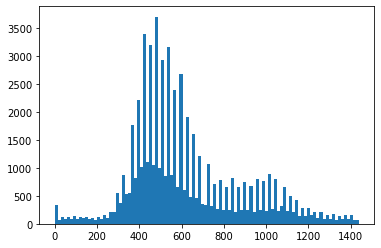

In [10]:
f = plt.hist(meta_df['time'], 100)
plt.show
# suspicious peak at t=0; remove?

In [11]:
# NORMALIZE METADATA
META_MEAN = []
META_STD = []
for col in ['latitude', 'longitude', 'date', 'time']:
    mean_col = meta_df[col].mean()
    std_col = meta_df[col].std()
    META_MEAN.append(mean_col)
    META_STD.append(std_col)
    meta_df[col] = ( meta_df[col] - mean_col) / std_col
meta_df

,filename,primary_label,latitude,longitude,date,time,rating
0,XC109605.ogg,acafly,0.493620,-0.108525,0.671402,-0.187007,2.5
1,XC11209.ogg,acafly,-0.693824,0.008098,2.178066,-0.081727,3.0
2,XC127032.ogg,acafly,-0.845445,0.109866,-1.712277,1.128996,3.0
3,XC129974.ogg,acafly,-0.895634,0.112912,0.075482,-0.563008,3.5
4,XC129981.ogg,acafly,-0.895634,0.112912,0.075482,-0.563008,3.5
...,...,...,...,...,...,...,...
62869,XC591680.ogg,yetvir,0.259728,-0.461020,0.311601,-0.412608,1.0
62870,XC600085.ogg,yetvir,0.806374,0.192155,-0.126906,-0.187007,5.0
62871,XC602701.ogg,yetvir,0.806374,0.192155,-0.115662,-0.412608,4.5
62872,XC614733.ogg,yetvir,0.351127,-0.519153,-0.509194,1.617798,4.0


In [12]:
# repeat each row in meta_df 'duration' times:
duration_df = pd.read_csv('../input/bird-dataset-20s/duration.csv', header=None)  # inport duration (n*5 seconds)
duration_df = duration_df[0]

# DEPENDS ON DATASET!

# 0) first5s
# # meta_df is left unchanged

# 1) whole dataset
# meta_df = meta_df.loc[meta_df.index.repeat(duration_df)]

# 2) dataset: rating >=4
# duration_df = duration_df.loc[meta_df.query('rating>=4').index]
# meta_df = meta_df.query('rating>=4')
# meta_df = meta_df.loc[meta_df.index.repeat(duration_df)]

# 3) first_last5s
# meta_df = meta_df.loc[meta_df.index.repeat(2)]

# 4) 10 seconds
# meta_df = meta_df.loc[duration_df.loc[duration_df>=2].index]   # 5*2=10
# duration_df = duration_df.loc[duration_df>=2]     # shape= 
# meta_df = meta_df.loc[meta_df.index.repeat(duration_df/2)]

# 5) 20 seconds
meta_df = meta_df.loc[duration_df.loc[duration_df>=4].index]     # 5*4=20
duration_df = duration_df.loc[duration_df>=4]                    # shape= 45278
meta_df = meta_df.loc[meta_df.index.repeat(duration_df/4)]

# 6) 30 seconds
# meta_df = meta_df.loc[duration_df.loc[duration_df>=6].index]   # 5*6=30
# duration_df = duration_df.loc[duration_df>=6]                  # shape= 45278
# meta_df = meta_df.loc[meta_df.index.repeat(duration_df/6)]

In [13]:
# get meta_tensor
meta_tensor = torch.tensor([meta_df['latitude'].values, meta_df['longitude'].values, meta_df['date'].values]).float()
meta_tensor = torch.transpose(meta_tensor, 0, 1)
meta_tensor.shape

torch.Size([144969, 3])

In [14]:
# create meta_dataset
meta_dataset = TensorDataset(meta_tensor)   # dataset without targets
len(meta_dataset) == len(dataset)

True

## Filtered data, train and validation sets

In [15]:
# loader = DataLoader(dataset, batch_size=1024, shuffle = False)

In [16]:
# # compute pixels mean on each row (avg pool on 128-pixel wide rectangles)
# # compute pixels sum on fixed size rectangles, then compare to mean (avg pool on smaller rectangles)

# from torch.nn import AvgPool2d

# Patch_averager = AvgPool2d(kernel_size =(8,7))         # filter1
# # Col_averager = AvgPool2d(kernel_size =(6,128*4))       # filter2
# # Patch_averager = AvgPool2d(kernel_size =(6,4))         # filter2

# good_array = np.array([]).astype(int)
# species_good_cnt = np.zeros(len(dataset.classes))

# tqdm_iterator = tqdm(
#     enumerate(loader),
#     total=len(loader),
#     leave=False,
# )
# batch_size = 1024
# for batch_idx, (data,target) in tqdm_iterator:

#     # filter1
#     AvgPatches = Patch_averager(data[:,:,:,:-2])
#     diff = torch.diff(AvgPatches, dim=3)
#     diff = diff.view(diff.shape[0], -1)
#     # select indices in each batch:
#     inner_idx_good = np.where(np.any(np.absolute(np.array(diff))>0.58,axis=1))[0].astype(int)

# #     # filter2
# #     AvgCol = Col_averager(data)         # 64x1x12
# #     AvgPatches = Patch_averager(data)
# #     diff = AvgPatches - AvgCol          # 64x1x12x32
# #     diff = diff.view(diff.shape[0], -1) # 64x(12*32)
# #     # select indices in each batch:
# #     inner_idx_good = np.where(np.any(np.array(diff)>0.63,axis=1))[0].astype(int)
# #     inner_idx_good = inner_idx_good[np.array(species_good_cnt[np.array(target.reshape(-1)[torch.tensor(inner_idx_good)])] < 4000)] 
    
#     # count species for each group
#     a1, b1 = np.unique(target[np.array(inner_idx_good)], return_counts = True)
#     species_good_cnt[a1] += b1
#     # create list for the entire dataset
#     good_indices = batch_idx*batch_size + inner_idx_good
#     good_array = np.append(good_array, good_indices)

# len(good_array)

In [17]:
# # good/all ratio

# all_birds = meta_df['primary_label'].value_counts(sort=False)
# all_birds, species_good_cnt/all_birds,

In [18]:
# thrown_away = all_birds - species_good_cnt
# plt.plot(list(range(len(dataset.classes))), species_good_cnt)
# plt.plot(list(range(len(dataset.classes))), thrown_away)
# plt.legend(['selected birds (tot {})' .format(species_good_cnt.sum()), 
#             'thrown away (tot {})' .format(thrown_away.sum())])
# plt.show()

In [19]:
# thrown_away = all_birds - species_good_cnt
# plt.plot(list(range(len(dataset.classes))), species_good_cnt/all_birds)
# plt.plot(list(range(len(dataset.classes))), thrown_away/all_birds)
# plt.legend(['% selected birds', '% thrown away'])
# plt.show()

In [20]:
# good_list = good_array.tolist()

# import csv
# with open('good_list4.1_1.8.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(list(range(len(good_list))))
#     writer.writerow(good_list)

In [21]:
# # good_list from file:
# good_df = pd.read_csv('../input/good-list/good_list4.1_1.5.csv')
# good_list = good_df.values.tolist()[0]

# len(good_list)

In [22]:
filtered = 0              # all data
# filtered = 1              # filtered data
# filtered = 2              # random data, len = len(good_list)

In [23]:
np.random.seed(0)
torch.manual_seed(0)

val_split_ratio = 0.2

if filtered == 0:
    VAL_TOT = int(np.floor(len(dataset)*val_split_ratio))
    dataset_indices = list(range(len(dataset)))
    np.random.shuffle(dataset_indices)
    split_index = int(np.floor(val_split_ratio*len(dataset)))
elif filtered == 1:
    VAL_TOT = int(np.floor(len(good_list)*val_split_ratio))
    dataset_indices = good_list
    np.random.shuffle(dataset_indices)
    split_index = int(np.floor(val_split_ratio*len(good_list)))
elif filtered == 2:           # RANDOM SAMPLES, same lenght as good_list
    VAL_TOT = int(np.floor(len(good_list)*val_split_ratio))
    dataset_indices = list(np.random.randint(low=0, high = len(dataset), size = len(good_list)))
    np.random.shuffle(dataset_indices)
    split_index = int(np.floor(val_split_ratio*len(good_list)))

train_idx, val_idx = dataset_indices[split_index:], dataset_indices[:split_index]

In [24]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=64, shuffle = False, sampler = train_sampler)
meta_train_loader = DataLoader(meta_dataset, batch_size=64, shuffle = False, sampler = train_sampler)
val_loader = DataLoader(dataset, batch_size=64, shuffle = False, sampler = val_sampler)
meta_val_loader = DataLoader(meta_dataset, batch_size=64, shuffle = False, sampler = val_sampler)

print("Batch data shape (train_loader):  ", next(iter(train_loader))[0].shape)
print("Number of batches (train_loader):  ", len(train_loader))

Batch data shape (train_loader):   torch.Size([64, 1, 48, 512])
Number of batches (train_loader):   1813


In [25]:
# # plotlib error =>
# from plotly.offline import plot, iplot, init_notebook_mode
# init_notebook_mode(connected=True)

## The model

In [26]:
class CNN(nn.Module):
    def __init__(self, input_size: int, input_channels: int, n_feature1: int, n_feature2: int, n_feature3: int, 
                 n_feature4: int, n_feature5: int, outputs: int) -> None:
        super().__init__()
        
        self.n_feature1 = n_feature1
        self.conv1 = nn.Conv2d(input_channels, n_feature1, kernel_size=3, padding = 'same')
        self.conv2 = nn.Conv2d(n_feature1, n_feature2, kernel_size=3, padding = 'same')
        self.conv3 = nn.Conv2d(n_feature2, n_feature3, kernel_size=3, padding = 'same')
        self.conv4 = nn.Conv2d(n_feature3, n_feature4, kernel_size=3, padding = 'same')
        self.conv5 = nn.Conv2d(n_feature4, n_feature5, kernel_size=3, padding = 'same')
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.bn1 = nn.BatchNorm2d(n_feature1)
        self.bn2 = nn.BatchNorm2d(n_feature2)
        self.bn3 = nn.BatchNorm2d(n_feature3)
        self.bn4 = nn.BatchNorm2d(n_feature4)
        self.bn5 = nn.BatchNorm2d(n_feature5)
        self.bnf1 = nn.BatchNorm1d(2048)        # modify along with fc dimensions

        self.drop2d = nn.Dropout2d(p=0.2)
        self.drop = nn.Dropout(p=0.4)
                
        self.meta_rep = 32
        
        self.fc1 = nn.Linear(n_feature5 * 1*16, 2048)          # 128(5s)->256(10s)->512(20s)->768(30s) => 4->8->16->24
        self.fc2 = nn.Linear(2048 + self.meta_rep*3, outputs)

    def forward(self, x: list) -> torch.Tensor:
        
        D = x[0]  # data
        M = x[1]  # meta
        Lat = M[:,0].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        Lon = M[:,1].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        Date = M[:,2].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        
#         #APPLY MASK
#         thresh = 0.5
#         Col_averager = AvgPool2d(kernel_size =(1,128))
#         condition = (D - Col_averager(D)) < thresh
#         D[condition] = 0
        
        #print(x.shape)                                               # torch.Size([64, 1, 48, 768] 512] 256] 128])
        D = self.drop2d(self.pool(self.bn1(F.relu(self.conv1(D))))) # [64, n_feature1, 24, 384] 256] 128] 64]
        D = self.drop2d(self.pool(self.bn2(F.relu(self.conv2(D))))) # [64, n_feature2, 12, 192] 128] 64] 32]
        D = self.drop2d(self.pool(self.bn3(F.relu(self.conv3(D))))) # [64, n_feature3, 6, 96] 64] 32] 16]
        D = self.drop2d(self.pool(self.bn4(F.relu(self.conv4(D))))) # [64, n_feature4, 3, 48] 32] 16] 8]
        D = self.drop2d(self.pool(self.bn5(F.relu(self.conv5(D))))) # [64, n_feature5, 1, 24] 16] 8] 4]
        
        
        D = D.view(D.shape[0], -1)        
        D = self.drop(self.bnf1(F.relu(self.fc1(D))))
        
        # ADD METADATA
        D = torch.cat((D, Lat, Lon, Date),1)    # data & meta
        
        D = self.fc2(D)
        return D

# identity + nn.CrossEntropyLoss = F.log_softmax + nn.NLLLoss

In [27]:
# (ReLU BEFORE AND AFTER ADDITION) +dropout 
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.drop2d = nn.Dropout2d(p=0.1)

    def forward(self, input):
        shortcut = self.shortcut(input)
        
        input = nn.ReLU()(self.bn1(self.conv1(input)))          # pool substituted with stride
        input = self.drop2d(input)
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [28]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.drop2d = nn.Dropout2d(p=0.2)      # batchnorm alone leads to overfitting

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = self.drop2d(input)
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = self.drop2d(input)
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [29]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=397):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
            self.meta_rep = 128
        else:
            filters = [64, 64, 128, 256, 512]
            self.meta_rep = 32

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4] + self.meta_rep*3, outputs)
        self.drop = nn.Dropout(p=0.4)

    def forward(self, input):
        
        D = input[0]  # data
        M = input[1]  # meta
        Lat = M[:,0].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        Lon = M[:,1].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        Date = M[:,2].unsqueeze(0).transpose(0,1).repeat(1,self.meta_rep)
        
        D = self.layer0(D)
        D = self.layer1(D)
        D = self.layer2(D)
        D = self.layer3(D)
        D = self.layer4(D)
        D = self.gap(D)                # [64, feature_maps, h, w] -> [64, feature_maps, 1]
        
        D = D.view(D.shape[0], -1)     # [64, feature_maps, 1, 1]    ->  [64, feature_maps]
        D = self.drop(D)
        
        DM = torch.cat((D, Lat, Lon, Date),1)    # data & meta
        
        DM = self.fc(DM)

        return DM

In [30]:
x, _ = next(iter(train_loader))
input_size_w, input_size_h = x.shape[2], x.shape[3]
input_size = input_size_w * input_size_h

# Define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cuda:0


In [31]:
# CNN
convnet5 = CNN(input_size, input_channels=1, n_feature1=32, n_feature2=64, n_feature3=128, n_feature4=256, n_feature5=512, outputs=397)
convnet5.to(device)

# resnet18
resnet18 = ResNet(1, ResBlock1, [2, 2, 2, 2], useBottleneck=False, outputs=397)
resnet18.to(device)

# resnet34
resnet34 = ResNet(1, ResBlock1, [3, 4, 6, 3], useBottleneck=False, outputs=397)
resnet34.to(device)

# resnet50
resnet50 = ResNet(1, ResBottleneckBlock, [3, 4, 6, 3], useBottleneck=True, outputs=397)
resnet50.to(device)

# resnet101
resnet101 = ResNet(1, ResBottleneckBlock, [3, 4, 23, 3], useBottleneck=True, outputs=397)
resnet101.to(device)

# resnet152
resnet152 = ResNet(1, ResBottleneckBlock, [3, 8, 36, 3], useBottleneck=True, outputs=397)
resnet152.to(device)

print('Models initialization')

Models initialization


In [32]:
def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")      # if count>0 => return total/count; if count=0 => return float('nan')
        count += 1
        total += new_value
        return total / count

    return averager

def test_model(
    loss_func,
    test_dl: torch.utils.data.DataLoader,
    meta_test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: str = "cuda"
) -> Dict[str, Union[float, Callable[[Optional[float]], float]]]:
    
    model.eval()
    test_loss_averager = make_averager()  # mantain a running average of the loss
    correct = 0
    with torch.no_grad():
        for (data, target),meta in zip(test_dl, meta_test_dl):
            # send to device
            meta = meta[0]
            data, target, meta = data.to(device), target.to(device), meta.to(device)
            output = model([data, meta])
    
            test_loss_averager(loss_func(output, target).item())   # takes the average of the losses (cross_entropy) computed on all samples of the test set

            # get the index of the max probability
            pred = output.max(1, keepdim=True)[1]               # dim to reduce=1 (max along each row); keep dimension; [1] => indices of the maxima, [0] => maxima
            correct += pred.eq(target.view_as(pred)).cpu().sum().item()  # "a.eq(b)" True if a=b; self.view_as(other) = self.view(other.size())

    return {
        "accuracy": 100.0 * correct / VAL_TOT,
        "loss_averager": test_loss_averager,
        "correct": correct,
    }

def fit(
    loss_func,
    epochs: int,
    train_dl: torch.utils.data.DataLoader,
    meta_train_dl: torch.utils.data.DataLoader,
    test_dl: torch.utils.data.DataLoader,
    meta_test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    opt: torch.optim.Optimizer,
    device: str = "cuda"
) -> float:
    
    for epoch in trange(epochs, desc="train epoch"):    # "trange" adds a bar, "desc" adds a description
        model.train()
        train_loss_averager = make_averager()  # mantain a running average of the loss

        # TRAIN
        tqdm_iterator = tqdm(                      # adds a progress bar
            enumerate(zip(train_dl,meta_train_dl)),
            total=len(train_dl),
            desc=f"batch [loss: None]",
            leave=False,
        )
        for batch_idx, ((data,target), meta) in tqdm_iterator:
            # send to device
            meta = meta[0]
            data, target, meta = data.to(device), target.to(device), meta.to(device)

            opt.zero_grad()
            output = model([data, meta])
            loss = loss_func(output, target)
            loss.backward()
            opt.step()
            
            train_loss_averager(loss.item())
            
            tqdm_iterator.set_description(
                f"train batch [avg loss: {train_loss_averager(None):.3f}]"
            )
            tqdm_iterator.refresh()
        
        scheduler.step()
        # TEST
        test_out = test_model(loss_func, test_dl, meta_test_dl, model,device)   # test_model outputs 'test_out' list

        print(
            f"Epoch: {epoch}\n"
            f"Train set: Average loss: {train_loss_averager(None):.4f}\n"
            f"Val set: Average loss: {test_out['loss_averager'](None):.4f}, "
            f"Accuracy: {test_out['correct']}/{VAL_TOT} "
            f"({test_out['accuracy']:.1f}%)\n"
        )
        train_losses.append(train_loss_averager(None))
        val_losses.append(test_out['loss_averager'](None))
        accuracy.append(test_out['correct']/VAL_TOT)

#     models_accuracy = test_out['accuracy']
    return test_out['accuracy']      # final accuracy
    
# Just a function to count the number of parameters
def count_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
from collections import Counter
dictionary = dict(Counter(dataset.targets))
number_per_class = np.array(list(dictionary.values()))
number_per_class.shape

(397,)

Number of parameters: 24494221


train epoch:   0%|          | 0/35 [00:00<?, ?it/s]

batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 0
Train set: Average loss: 5.0134
Val set: Average loss: 4.3006, Accuracy: 3779/28993 (13.0%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 1
Train set: Average loss: 3.9188
Val set: Average loss: 3.3970, Accuracy: 7839/28993 (27.0%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 2
Train set: Average loss: 3.3262
Val set: Average loss: 2.9813, Accuracy: 10167/28993 (35.1%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 3
Train set: Average loss: 2.9175
Val set: Average loss: 2.5616, Accuracy: 12644/28993 (43.6%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 4
Train set: Average loss: 2.6261
Val set: Average loss: 2.3547, Accuracy: 13732/28993 (47.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 5
Train set: Average loss: 2.4155
Val set: Average loss: 2.1293, Accuracy: 15223/28993 (52.5%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 6
Train set: Average loss: 2.2443
Val set: Average loss: 1.9525, Accuracy: 16222/28993 (56.0%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 7
Train set: Average loss: 2.1039
Val set: Average loss: 1.8496, Accuracy: 16937/28993 (58.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 8
Train set: Average loss: 1.9845
Val set: Average loss: 1.7616, Accuracy: 17516/28993 (60.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 9
Train set: Average loss: 1.8839
Val set: Average loss: 1.7437, Accuracy: 17617/28993 (60.8%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 10
Train set: Average loss: 1.7405
Val set: Average loss: 1.5757, Accuracy: 18718/28993 (64.6%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 11
Train set: Average loss: 1.6707
Val set: Average loss: 1.4919, Accuracy: 19304/28993 (66.6%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 12
Train set: Average loss: 1.6007
Val set: Average loss: 1.4958, Accuracy: 19154/28993 (66.1%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 13
Train set: Average loss: 1.5461
Val set: Average loss: 1.4004, Accuracy: 19759/28993 (68.2%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 14
Train set: Average loss: 1.4952
Val set: Average loss: 1.3759, Accuracy: 19920/28993 (68.7%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 15
Train set: Average loss: 1.4502
Val set: Average loss: 1.3498, Accuracy: 20109/28993 (69.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 16
Train set: Average loss: 1.4043
Val set: Average loss: 1.3284, Accuracy: 20156/28993 (69.5%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 17
Train set: Average loss: 1.3669
Val set: Average loss: 1.2681, Accuracy: 20645/28993 (71.2%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 18
Train set: Average loss: 1.3199
Val set: Average loss: 1.2574, Accuracy: 20717/28993 (71.5%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 19
Train set: Average loss: 1.2843
Val set: Average loss: 1.2075, Accuracy: 21045/28993 (72.6%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 20
Train set: Average loss: 1.2091
Val set: Average loss: 1.1725, Accuracy: 21253/28993 (73.3%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 21
Train set: Average loss: 1.1703
Val set: Average loss: 1.1347, Accuracy: 21568/28993 (74.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 22
Train set: Average loss: 1.1425
Val set: Average loss: 1.1021, Accuracy: 21768/28993 (75.1%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 23
Train set: Average loss: 1.1189
Val set: Average loss: 1.1023, Accuracy: 21766/28993 (75.1%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 24
Train set: Average loss: 1.0951
Val set: Average loss: 1.0763, Accuracy: 22002/28993 (75.9%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 25
Train set: Average loss: 1.0715
Val set: Average loss: 1.0812, Accuracy: 22004/28993 (75.9%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 26
Train set: Average loss: 1.0484
Val set: Average loss: 1.0691, Accuracy: 22010/28993 (75.9%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 27
Train set: Average loss: 1.0267
Val set: Average loss: 1.0522, Accuracy: 22103/28993 (76.2%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 28
Train set: Average loss: 0.9987
Val set: Average loss: 1.0223, Accuracy: 22310/28993 (76.9%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 29
Train set: Average loss: 0.9830
Val set: Average loss: 1.0286, Accuracy: 22215/28993 (76.6%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 30
Train set: Average loss: 0.9363
Val set: Average loss: 0.9753, Accuracy: 22666/28993 (78.2%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 31
Train set: Average loss: 0.9097
Val set: Average loss: 0.9605, Accuracy: 22760/28993 (78.5%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 32
Train set: Average loss: 0.8955
Val set: Average loss: 0.9698, Accuracy: 22732/28993 (78.4%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 33
Train set: Average loss: 0.8783
Val set: Average loss: 0.9451, Accuracy: 22841/28993 (78.8%)



batch [loss: None]:   0%|          | 0/1813 [00:00<?, ?it/s]

Epoch: 34
Train set: Average loss: 0.8627
Val set: Average loss: 0.9364, Accuracy: 22975/28993 (79.2%)



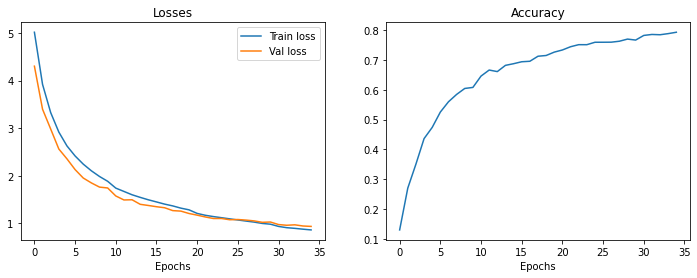

In [34]:
epochs = 35
fit_model = 1
model = resnet50

train_losses, val_losses, accuracy = [], [], []
class_weights = 1 - number_per_class/len(dataset)
class_weights = torch.tensor(class_weights).to(torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)  # decays lr of each par. group by gamma every step_size epochs
loss_func = nn.CrossEntropyLoss(weight = class_weights)
print(f'Number of parameters: {count_parameters(model)}')
tqdm._instances.clear()

if fit_model:
    fit(loss_func = loss_func,
    epochs=epochs,
    train_dl=train_loader,
    meta_train_dl = meta_train_loader,
    test_dl=val_loader,
    meta_test_dl = meta_val_loader,
    model=model,
    opt=optimizer,
    device=device)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].set_title('Losses')
    axs[0].plot(train_losses, label='Train loss')
    axs[0].plot(val_losses, label='Val loss')
    axs[0].legend()
    axs[1].plot(accuracy)
    axs[1].set_title('Accuracy')
    for ax in axs.flat:
        ax.set(xlabel='Epochs')

In [35]:
save = 1
from datetime import datetime
import pytz
if save:
    timezone = pytz.timezone('Europe/Rome')
    now = datetime.now(tz = timezone)
    time_info = now.strftime("%d-%m--%H-%M")
    model_name = 'ResNet50_V2' + '.pt' #+ '_' + time_info 
    model_path = os.path.join('./', model_name)   # ./model_name.pt
    torch.save(model.state_dict(), model_path)

# os.remove(os.path.join(output_dir, 'model_cnn_200'))

In [36]:
import shutil
shutil.rmtree('./dataset')

## Soundscapes

In [37]:
# model.load_state_dict(torch.load('../input/net50-meta128-masks-timerec-09051425/Net50_meta128_masks_timerec_09-05--14-25.pt',
#                                      map_location=torch.device('cpu')))

In [38]:
def get_TEST_landscape_spectrograms(audio_path, output_dir):
    
    sig, rate = librosa.load(audio_path, sr=SAMPLING_RATE, offset=None)
    
    lunp_samples = int(INPUT_LENGTH*SAMPLING_RATE)   # number of time samples in a 5s piece of signal (5s*32000Hz)
    
    # split signal into five second lumps
    sig_splits = []
    for i in range(0, len(sig), lunp_samples):
        split = sig[i:i + lunp_samples]

        # End of signal
        if len(split) < lunp_samples:
            break
        sig_splits.append(split)
    
    # extract mel spectrograms
    split_count = 0
    samples = []
    for lump in sig_splits:
        
        HOP_LENGTH = int((INPUT_LENGTH*SAMPLING_RATE)/(SPEC_SHAPE[1]-1))
        mel_spec = librosa.feature.melspectrogram(y=lump,
                                                 sr=SAMPLING_RATE,
                                                 n_fft=1024,
                                                 hop_length=HOP_LENGTH,
                                                 n_mels=SPEC_SHAPE[0],
                                                 fmin=FMIN,
                                                 fmax=FMAX)
        
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        # THIS TIME IN A SINGLE FOLDER (NO LABELS):
        save_path = os.path.join(output_dir, audio_path.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0].rsplit('_',1)[0] + 
                                 '_' + str((split_count+1)*5) + '.png')
        
        im = Image.fromarray(mel_spec * 255.0).convert("L") # color -> greyscale (mode “L”): L = R * 299/1000 + G * 587/1000 + B * 114/1000
        im.save(save_path)
        
        samples.append(save_path)
        split_count += 1
            
    filename = audio_path.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0]
    location = filename.rsplit('_',2)[1]
    meta_lat.append(geo_map[filename.rsplit('_',2)[1]][0])
    meta_lon.append(geo_map[filename.rsplit('_',2)[1]][1])
    date = filename.rsplit('_',1)[1][0:4] + '-' + filename.rsplit('_',1)[1][4:6] + '-' + filename.rsplit('_',1)[1][6:8]
    meta_date.append(date_transform(date))
    return samples

In [39]:
# EXTRACT TEST SPECTROGRAMS

if not os.path.isdir('./TEST_SOUNDSCAPES_MEL_DATASET'):
    !pip install natsort
    import librosa
    from natsort import natsorted

    # os.rmdir('./TEST_SOUNDSCAPES_MEL_DATASET')

    input_dir = '../input/birdclef-2021/train_soundscapes'
    output_dir = './TEST_SOUNDSCAPES_MEL_DATASET'
    os.makedirs(output_dir)
    TEST_SPECS = []
    geo_map = {'COL': [5.57,-75.85], 'COR':[10.12, -84.51], 'SNE':[38.49,-119.95], 'SSW':[42.47,-76.45]}
    meta_lat = []
    meta_lon = []
    meta_date = []

    # ORDER LIST OF FILENAMES according to train_soundscapes_labels.csv: COL-COR-SNE-SSW, ID NUMBER
    filename_list = natsorted(os.listdir(input_dir))
    COL_list = []
    COR_list = []
    SNE_list = []
    SSW_list = []
    for filename in filename_list:
        if 'COL' in filename:
            COL_list.append(filename)
        if 'COR' in filename:
            COR_list.append(filename)
        if 'SNE' in filename:
            SNE_list.append(filename)
        if 'SSW' in filename:
            SSW_list.append(filename)

    ordered_list = COL_list + COR_list + SNE_list + SSW_list
    # print(ordered_list)

    for filename in ordered_list:
        audio_file_path = os.path.join(input_dir, filename)
        TEST_SPECS += get_TEST_landscape_spectrograms(audio_file_path, output_dir)

    print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TEST_SPECS)))  # 2400

SUCCESSFULLY EXTRACTED 2400 SPECTROGRAMS


In [40]:
# import shutil
# shutil.rmtree('./TEST_SOUNDSCAPES_MEL_DATASET')

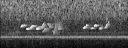

In [41]:
image = Image.open('./TEST_SOUNDSCAPES_MEL_DATASET/11254_COR_5.png')
image

In [42]:
# META
meta_sound_df = pd.DataFrame(list(zip(meta_lat, meta_lon, meta_date)), columns =['latitude', 'longitude', 'date'])
print(meta_sound_df)

# NORMALIZE 
for idx, col in enumerate(['latitude', 'longitude', 'date']):
    meta_sound_df[col] = ( meta_sound_df[col] - META_MEAN[idx] ) / META_STD[idx]

a = meta_sound_df.columns    
# REPEAT: repeat each row in meta_sound_df 600s/5s times:
meta_sound_df = pd.DataFrame(np.repeat(meta_sound_df.values, 120, axis=0))
meta_sound_df.columns = a
meta_sound_df.shape

    latitude  longitude  date
0      10.12     -84.51   244
1      10.12     -84.51   263
2      10.12     -84.51   244
3      10.12     -84.51   244
4      10.12     -84.51   244
5      10.12     -84.51   274
6      10.12     -84.51   274
7      10.12     -84.51   263
8      10.12     -84.51   274
9      10.12     -84.51   244
10     42.47     -76.45   181
11     42.47     -76.45    85
12     42.47     -76.45   119
13     42.47     -76.45   181
14     42.47     -76.45   215
15     42.47     -76.45   181
16     42.47     -76.45    98
17     42.47     -76.45   188
18     42.47     -76.45   133
19     42.47     -76.45   167


(2400, 3)

In [43]:
meta_sound_tensor = torch.tensor([meta_sound_df['latitude'].values, meta_sound_df['longitude'].values, meta_sound_df['date'].values]).float()
meta_sound_tensor = torch.transpose(meta_sound_tensor, 0, 1)
# meta_sound_tensor, meta_sound_tensor.shape

In [44]:
transform_inference =  transforms.Compose([transforms.Grayscale(), 
                                           transforms.ToTensor(), 
                                           transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)])
def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform_inference(image)
    image = image.unsqueeze(0)  # adds dimension 0 of size 1 (batch dim) to obtain 1x1x48x128
    if device.type == 'cuda':
        return image.cuda()
    else:
        return image

In [45]:
# birds frequently mispredicted as nocalls:
# birds_as_nocalls10 = list(['bkcchi', 'bobfly1', 'chswar', 'comyel', 'eastow', 'reevir1', 'rewbla', 'rucwar', 'sonspa'])

# nocalls frequently mispredicted as birds:
# nocalls_as_birds10 = list(['bcnher', 'bkcchi', 'carchi', 'grhowl', 'rewbla', 'whtspa'])     # too many grhowls ('great horned owl')!

In [46]:
# list in a dataframe pair of birds frequently heard together
from itertools import combinations
truth = pd.read_csv('../input/birdclef-2021/train_soundscape_labels.csv')

groups = truth[truth['birds'].str.split().str.len() > 1]
groups['birds'] = groups['birds'].apply(lambda x: list(combinations(x.split(' '), 2)))
pairs = groups.explode('birds', ignore_index=True)
pairs_count = pd.DataFrame(np.stack(np.unique(pairs['birds'], return_counts = True), axis = 1),
                                   columns = ['birds', 'occurrences'])
common_pairs = pairs_count[pairs_count['occurrences']>10]
common_pairs['birds'] = [' '.join(map(str, l)) for l in common_pairs['birds']]
common_pairs = common_pairs.sort_values(by=['occurrences'], ascending=False)
common_pairs

,birds,occurrences
43,eawpew reevir1,78
19,bkcchi reevir1,33
50,grycat reevir1,31
15,bkcchi eawpew,23
42,eawpew grycat,20
8,balori grycat,15
58,rewbla sonspa,11


In [47]:
# Predict MULTILABEL
test_soundscapes_dir =  './TEST_SOUNDSCAPES_MEL_DATASET'
from torch.nn import AvgPool2d
from collections import deque

Col_averager = AvgPool2d(kernel_size =(6,128*4))                     # 20 seconds
Patch_averager = AvgPool2d(kernel_size =(6,4))
last_saved = 0         # saved last_birds number (between these, accept lower probabilities for species1)
X = 10                  # number of highest score guesses to check for birds related to species1 (multilabel)
multilabel = False

# Store the results
data = {'row_id': [], 'prediction': [], 'score': []}
with torch.no_grad():
    cnt = 0
    last_birds = deque(maxlen=last_saved)
    for idx, spec_name in enumerate(os.listdir(test_soundscapes_dir)):
        if idx % 120 == 0:                               # new 10 minutes audio (120*5s)
            last_birds = deque(maxlen=last_saved)
            print('audio n. ', int(idx/120))
        path = os.path.join(test_soundscapes_dir, spec_name)
        
        spec = image_loader(path)
        meta = meta_sound_tensor[idx].unsqueeze(0)
        spec, meta = spec.to(device), meta.to(device)
        model.eval()
        
        # repeat 2/4/6 times to reach 10/20/30 seconds
        spec = torch.cat((spec, spec, spec, spec),-1)               # 20 seconds
        prediction = nn.functional.softmax(model([spec, meta]))[0]
        prediction = torch.Tensor.cpu(prediction)
        
        # store 1st, 2nd and first X guesses (the latter to be used in case of birds frequently heard together)
        idx2,idx1 = np.argpartition(prediction, -2)[-2:]            # indices of the 2 highest scores (max on the right)
        bestX_idx = np.argpartition(prediction, -X)[-X:]            # indices of the X highest scores
        species1, species2 = all_species[idx1], all_species[idx2]
        score1, score2 = prediction[idx1], prediction[idx2]         # 2 highest scores
        bestX = list(all_species[bestX_idx])                        # X highest scores
        bestX.remove(species1)                                      # (species1 removed)
        
        data['row_id'].append(spec_name.rsplit('.', 1)[0])
        
        # filter2: separate birdcalls | nocalls
        AvgCol = Col_averager(spec)            # 1x1x8x1
        AvgPatches = Patch_averager(spec)      # 1x1x8x128
        diff = AvgPatches - AvgCol             # 1x1x8x128
        diff = diff.view(diff.shape[0], -1)    # 1x(8*128)
        birdcall = np.any(np.absolute(np.array(torch.Tensor.cpu(diff)))>0.63, axis=1)
        
        bird2_flag = 0
        if birdcall and (species1 != 'grhowl') and (score1>0.33 or (last_birds.count(species1)>=3 and score1>0.15)):# or (species1 in birds_as_nocalls10 and score1>0.3):
            last_birds.append(species1)
            has_rel_birds = common_pairs['birds'].str.contains(species1)                   # if 'common_pairs' rows contain species1
            if any(has_rel_birds):
                rel_pairs = pd.DataFrame(common_pairs.loc[has_rel_birds])                  # rows containing species1
                bestX_pattern = '|'.join(bestX)
                rel_pairs['in_bestX'] = rel_pairs['birds'].str.contains(bestX_pattern)     # rows True if bird2 in row is in bestX
                rel_pairs_in10 = rel_pairs.loc[rel_pairs['in_bestX']]['birds'].to_list()   # list of pairs with bird2 in bestX
                if rel_pairs_in10:
                    rel_bird = rel_pairs_in10[0].rsplit(' ')            # keep first pair, split it
                    rel_bird.remove(species1)                           # bird related to species1
                    rel_bird = str(rel_bird)
                    bird2_flag = 1
                    species2 = rel_bird
            
            if score1 < 0.37:     # add 'nocall' label anyway
                if multilabel and bird2_flag:                            # multi-birds label is inaccurate
                    data['prediction'].append({species1, species2, 'nocall'})
                    cnt +=2
                else:
                    data['prediction'].append({species1, 'nocall'})
                    cnt += 1
            else:
                if multilabel and bird2_flag:
                    data['prediction'].append({species1, species2})
                    cnt +=2
                else:
                    data['prediction'].append({species1})
                    cnt += 1
        else:
            data['prediction'].append({'nocall'})
        # Add the confidence score
        data['score'].append( str(score1.item()) + ' ' + str(score2.item()) )

print('SOUNDSCAPE ANALYSIS DONE. FOUND {} BIRDS.'.format(cnt))

audio n.  0
audio n.  1
audio n.  2
audio n.  3
audio n.  4
audio n.  5
audio n.  6
audio n.  7
audio n.  8
audio n.  9
audio n.  10
audio n.  11
audio n.  12
audio n.  13
audio n.  14
audio n.  15
audio n.  16
audio n.  17
audio n.  18
audio n.  19
SOUNDSCAPE ANALYSIS DONE. FOUND 549 BIRDS.


In [48]:
results = pd.DataFrame(data, columns = ['row_id', 'prediction', 'score'])       # new dataframe
results = pd.merge(truth, results, on='row_id')                                 # merge with true labels

# Let's look at some entries
results[1900:1950]

,row_id,site,audio_id,seconds,birds,prediction,score
1900,26709_SSW_505,SSW,26709,505,eastow,{nocall},0.7480048537254333 0.06089242175221443
1901,26709_SSW_510,SSW,26709,510,eastow,{nocall},0.48238813877105713 0.12134802341461182
1902,26709_SSW_515,SSW,26709,515,eastow,{nocall},0.8110538125038147 0.023337651044130325
1903,26709_SSW_520,SSW,26709,520,eastow,{nocall},0.8313433527946472 0.03737930953502655
1904,26709_SSW_525,SSW,26709,525,eastow,{rewbla},0.7335543632507324 0.09521211683750153
1905,26709_SSW_530,SSW,26709,530,eastow sonspa,{nocall},0.38135746121406555 0.08367152512073517
1906,26709_SSW_535,SSW,26709,535,nocall,{nocall},0.4161088168621063 0.0764479711651802
1907,26709_SSW_540,SSW,26709,540,nocall,{nocall},0.4097125232219696 0.1295786201953888
1908,26709_SSW_545,SSW,26709,545,sonspa,{nocall},0.7308271527290344 0.07250505685806274
1909,26709_SSW_550,SSW,26709,550,nocall,{nocall},0.7846575975418091 0.09637940675020218


In [49]:
all_species_nocall = np.append('nocall', all_species)

from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes = all_species_nocall)

y_prediction = list(results['prediction'])
y_pred_matrix = mlb.fit_transform(y_prediction)

# true birds list to list of sets
y_truth = []
for element in list(results['birds']):
    y_truth.append(set(element.split()))
y_true_matrix = mlb.fit_transform(y_truth)

f1 = f1_score(y_true_matrix, y_pred_matrix, average='micro')
print('F1 = %.3f' %(f1))

f1_398 = f1_score(y_true_matrix, y_pred_matrix, average=None)            # f1 for each class
print('\n', 'F1_classes:\n', f1_398)

F1 = 0.570

 F1_classes:
 [0.81831438 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.26086957 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05405405 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.18181818 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.5        0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

In [50]:
# Predict ONELABEL
test_soundscapes_dir =  './TEST_SOUNDSCAPES_MEL_DATASET'
from torch.nn import AvgPool2d

Col_averager = AvgPool2d(kernel_size =(6,128*4))                     # 20 seconds
Patch_averager1 = AvgPool2d(kernel_size =(6,4))
Patch_averager2 = AvgPool2d(kernel_size =(8,7))

# Store the results
data = {'row_id': [], 'prediction': [], 'score': []}
data_no_grhowl = {'row_id': [], 'prediction': [], 'score': []}
data_no_grhowl_thresh = {'row_id': [], 'prediction': [], 'score': []}

with torch.no_grad():
    cnt1,cnt2,cnt3 = 0, 0, 0
    for idx, spec_name in enumerate(os.listdir(test_soundscapes_dir)):
        path = os.path.join(test_soundscapes_dir, spec_name)
        
        spec = image_loader(path)
        meta = meta_sound_tensor[idx].unsqueeze(0)
        spec, meta = spec.to(device), meta.to(device)
        model.eval()
        
        # ripeto per 2/4/6 così raggiungo 10/20/30 secondi
        spec = torch.cat((spec, spec, spec, spec),-1)                            # 20 seconds
        prediction = nn.functional.softmax(model([spec, meta]))[0]
        prediction = torch.Tensor.cpu(prediction)
        idx = np.argmax(prediction)     # highest score index
        species = all_species[idx]
        score = prediction[idx]         # highest score

        data['row_id'].append(spec_name.rsplit('.', 1)[0])
        data_no_grhowl['row_id'].append(spec_name.rsplit('.', 1)[0])
        data_no_grhowl_thresh['row_id'].append(spec_name.rsplit('.', 1)[0])
        
        AvgCol = Col_averager(spec)
        AvgPatches = Patch_averager1(spec)
        diff = AvgPatches - AvgCol
        diff = diff.view(diff.shape[0], -1)
        val = int(np.any(np.absolute(np.array(torch.Tensor.cpu(diff)))>0.63, axis=1))

        #1
        if val:
            data['prediction'].append(species)
            cnt1 += 1
        else:
            data['prediction'].append('nocall')
        
        #2
        if val and species != 'grhowl':
            data_no_grhowl['prediction'].append(species)
            cnt2 += 1
        else:
            data_no_grhowl['prediction'].append('nocall')   
        
        #3
        if val and species != 'grhowl' and score>0.33:
            data_no_grhowl_thresh['prediction'].append(species)
            cnt3 += 1
        else:
            data_no_grhowl_thresh['prediction'].append('nocall')   
        
        # Add the confidence score
        data['score'].append(score.item())
        data_no_grhowl['score'].append(score.item())
        data_no_grhowl_thresh['score'].append(score.item())

print('SOUNDSCAPE ANALYSIS DONE. FOUND {0}, {1}, {2} BIRDS.'.format(cnt1, cnt2, cnt3))

SOUNDSCAPE ANALYSIS DONE. FOUND 1021, 923, 549 BIRDS.


In [51]:
# data
results = pd.DataFrame(data, columns = ['row_id', 'prediction', 'score'])       # new dataframe
results = pd.merge(truth, results, on='row_id')                                 # merge with true labels

only_birds = results.loc[results['birds'] != 'nocall']           # dataframe: only rows with truth != 'nocall'
n_birds = only_birds.shape[0]                                    # rows with truth != 'nocall': shape= (871, 7)
n_nocalls = results.loc[results['birds'] == 'nocall'].shape[0]   # rows with truth == 'nocall': shape= (1529, 7) (63%)

correct_birds = sum([x[0] in x[1] for x in zip(only_birds['prediction'], only_birds['birds'])])                  # birds correctly predicted
correct_nocalls = results.loc[results['birds'] == 'nocall'][results['birds'] == results['prediction']].shape[0]  # nocall correctly predicted
birds_as_birds = only_birds[results['prediction'] != 'nocall'].shape[0]                                          # birds predicted as birds:

print('Correct birds:', correct_birds, '(%.3f %%)' %((correct_birds/n_birds)*100))
print('Birds predicted as birds:', birds_as_birds, '(%.3f %%)' %((birds_as_birds/n_birds)*100))
print('Correct nocalls:', correct_nocalls, '(%.3f %%)' %((correct_nocalls/n_nocalls)*100))

Correct birds: 76 (8.726 %)
Birds predicted as birds: 657 (75.431 %)
Correct nocalls: 1165 (76.194 %)


In [52]:
# data, no 'grhowl' label  -> 3% of birds predicted as birds are grhowl, but they were misclassified
results = pd.DataFrame(data_no_grhowl, columns = ['row_id', 'prediction', 'score'])    # new dataframe
results = pd.merge(truth, results, on='row_id')                                        # merge with true labels

only_birds = results.loc[results['birds'] != 'nocall']           # dataframe: only rows with truth != 'nocall'

correct_birds = sum([x[0] in x[1] for x in zip(only_birds['prediction'], only_birds['birds'])])                  # birds correctly predicted
correct_nocalls = results.loc[results['birds'] == 'nocall'][results['birds'] == results['prediction']].shape[0]  # nocall correctly predicted
birds_as_birds = only_birds[results['prediction'] != 'nocall'].shape[0]                                          # birds predicted as birds:

print('Correct birds:', correct_birds, '(%.3f %%)' %((correct_birds/n_birds)*100))
print('Birds predicted as birds:', birds_as_birds, '(%.3f %%)' %((birds_as_birds/n_birds)*100))
print('Correct nocalls:', correct_nocalls, '(%.3f %%)' %((correct_nocalls/n_nocalls)*100))

Correct birds: 76 (8.726 %)
Birds predicted as birds: 642 (73.708 %)
Correct nocalls: 1248 (81.622 %)


In [53]:
# data, no 'grhowl' label, score threshold  -> 21% of birds predicted as birds have score<0.28, but they provided only 1% of correct birds
results = pd.DataFrame(data_no_grhowl_thresh, columns = ['row_id', 'prediction', 'score'])   # dataframe
results = pd.merge(truth, results, on='row_id')                                              # merge with true labels

only_birds = results.loc[results['birds'] != 'nocall']           # dataframe: only rows with truth != 'nocall'

correct_birds = sum([x[0] in x[1] for x in zip(only_birds['prediction'], only_birds['birds'])])                  # birds correctly predicted
correct_nocalls = results.loc[results['birds'] == 'nocall'][results['birds'] == results['prediction']].shape[0]  # nocall correctly predicted
birds_as_birds = only_birds[results['prediction'] != 'nocall'].shape[0]                                          # birds predicted as birds:

print('Correct birds:', correct_birds, '(%.3f %%)' %((correct_birds/n_birds)*100))
print('Birds predicted as birds:', birds_as_birds, '(%.3f %%)' %((birds_as_birds/n_birds)*100))
print('Correct nocalls:', correct_nocalls, '(%.3f %%)' %((correct_nocalls/n_nocalls)*100))

Correct birds: 67 (7.692 %)
Birds predicted as birds: 414 (47.532 %)
Correct nocalls: 1394 (91.171 %)


In [54]:
# birds predicted as nocalls
birds_as_nocalls = only_birds[results['prediction'] == 'nocall']
# divide group of birds to get total number of occurrence per bird
birds_as_nocalls_SPLIT = birds_as_nocalls.assign(birds=birds_as_nocalls['birds'].str.split(' ')).explode('birds')
# create dataframe with number of occurrences
birds_as_nocalls_df = pd.DataFrame(np.stack(np.unique(birds_as_nocalls_SPLIT['birds'], return_counts = True), axis = 1),
                                   columns = ['birds', 'number'])
most_freq_mispredicted_birds = birds_as_nocalls_df.loc[birds_as_nocalls_df['number'] > 10].sort_values('number', ascending = False)
most_freq_mispredicted_birds

,birds,number
33,reevir1,96
36,rucwar,63
38,sonspa,58
34,rewbla,52
4,bkcchi,48
17,eawpew,41
6,bobfly1,39
21,grycat,24
13,comyel,20
10,chswar,15


In [55]:
# nocalls predicted as birds
# nocalls_as_birds = only_nocalls[results['prediction'] != 'nocall']
# # create dataframe with number of occurrences
# nocalls_as_birds_df = pd.DataFrame(np.stack(np.unique(nocalls_as_birds['prediction'], return_counts = True), axis = 1),
#                                    columns = ['birds', 'number'])
# most_freq_mispredicted_nocalls = nocalls_as_birds_df.loc[nocalls_as_birds_df['number'] > 10]
# most_freq_mispredicted_nocalls

In [56]:
# onelabel accuracy (no additional 'nocall' label if score<0.35)
# with last results = pd.DataFrame(data_no_grhowl_thresh, ...) :
f1 = f1_score(results['prediction'], results['birds'], average = 'micro')
accuracy = sum([x[0] in x[1] for x in zip(results['prediction'], results['birds'])])/2400
print('Accuracy = %.1f %%' %(accuracy*100))
print('F1 = %.5f' %(f1))

# Test accuracy (on train_soundscapes) of a fake model classifying all as 'nocall' is 63.7%!!!

Accuracy = 60.9 %
F1 = 0.59708


In [57]:
import shutil
shutil.rmtree('./TEST_SOUNDSCAPES_MEL_DATASET')